In [ ]:
!pip install fastf1

In [ ]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import requests

Only change the variable ***rounds*** and ***title GP***

In [ ]:
def ergast_retrieve(api_endpoint: str):
    url = f'https://ergast.com/api/f1/{api_endpoint}.json'
    response = requests.get(url).json()

    return response['MRData']

In [ ]:
# Current round
rounds = 14

# Empty dataframe to store our data
all_championship_standings = pd.DataFrame()

# We also want to store which driver drives for which team, which will help us later
driver_team_mapping = {}

# Initate a loop through all the rounds
for i in range(1, rounds + 1):
    # Make request to driverStandings endpoint for the current round
    race = ergast_retrieve(f'current/{i}/driverStandings')

    # Get the standings from the result
    standings = race['StandingsTable']['StandingsLists'][0]['DriverStandings']

    # Initiate a dictionary to store the current rounds' standings in
    current_round = {'round': i}

    # Loop through all the drivers to collect their information
    for i in range(len(standings)):
        driver = standings[i]['Driver']['code']
        position = standings[i]['position']

        # Store the drivers' position
        current_round[driver] = int(position)

        # Create mapping for driver-team to be used for the coloring of the lines
        driver_team_mapping[driver] = standings[i]['Constructors'][0]['name']

    # Append the current round to our fial dataframe
    all_championship_standings = all_championship_standings.append(current_round, ignore_index=True)

# Set the round as the index of the dataframe
all_championship_standings = all_championship_standings.set_index('round')

In [ ]:
# Melt data so it can be used as input for plot
driver_standings = pd.melt(all_championship_standings.reset_index(), ['round'])

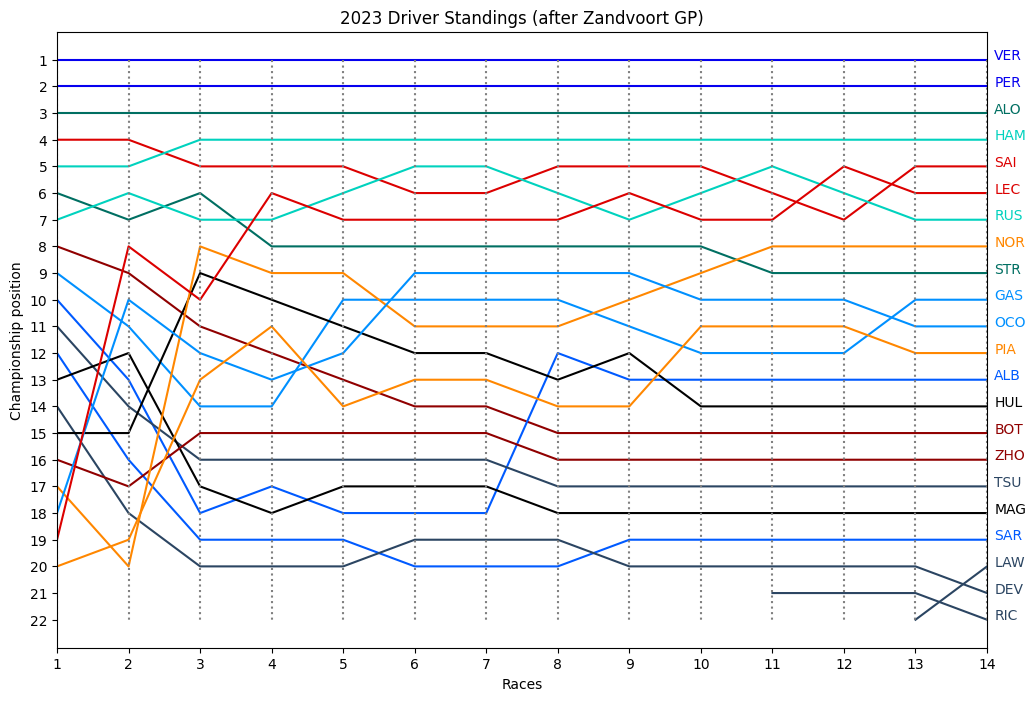

In [ ]:
# Initiate the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the title of the plot
ax.set_title("2023 Driver Standings (after Zandvoort GP)")

colores_personalizados = {'HUL': 'black', 'MAG': 'black'}

# Draw a line for every driver in the data by looping through all the standings
for driver in pd.unique(driver_standings['variable']):
    data_driver = driver_standings.loc[driver_standings['variable'] == driver]
    color = colores_personalizados.get(driver, None)

    if color is None:
        sns.lineplot(x='round', y='value', data=data_driver, color=ff1.plotting.team_color(driver_team_mapping[driver]), ax=ax)
    else:
        sns.lineplot(x='round', y='value', data=data_driver, color=color, ax=ax)

# Invert Y-axis to have championship leader (#1) on top
ax.invert_yaxis()

# Set the values and limits that appear on the x- and y-axes
ax.set_xticks(range(1, rounds+1))
ax.set_yticks(range(1, 23))
ax.set_xlim(1, rounds)

# Set the labels of the axes
ax.set_xlabel("Races")
ax.set_ylabel("Championship position")

# Disable the gridlines
ax.grid(False)

# Add the driver name to the lines
for line, name in zip(ax.lines, all_championship_standings.columns.tolist()):
    y = line.get_ydata()[-1]
    x = line.get_xdata()[-1]

    text = ax.annotate(name, xy=(x + 0.1, y), xytext=(0, 0), color=line.get_color(),
                       xycoords=(ax.get_xaxis_transform(), ax.get_yaxis_transform()), textcoords="offset points")

# Draw vertical lines behind the bars
for x_value in range(1, rounds + 1):
    ax.vlines(x=x_value, ymin=1, ymax=22, linestyles='dotted', colors='grey')

# Save the plot
#plt.savefig('/content/drive/MyDrive/F1/championship_standings.png')

plt.show()